In [1]:
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import time
import math
IOFOLDER='../../DGD_IO/'

In [2]:
def val(P,x):
    return P[0]+P[1]*x+P[2]*x*x
def grad(P,x):
    return P[1]+P[2]*2*x

In [3]:
def find(dsu,i):
    if dsu[i]==i:
        return i
    dsu[i]=find(dsu,dsu[i])
    return dsu[i]
def merge(dsu,i,j):
    dsu[find(dsu,i)]=find(dsu,j)
def connected(G):
    dsu=[i for i in range(len(G))]
    for i in range(len(G)):
        for j in G[i]:
            merge(dsu,i,j)
    for i in range(len(G)):
        if (find(dsu,i)!=find(dsu,0)):
            return (False,dsu)
    return (True,dsu)

In [5]:
#TODO: TEST RANDOM GRAPH
#TODO: TEST EQUIVOCATING ADVERSARY
#parameters/other variables to adjust
N,P=50,0.05
gseed=1
print('gseed='+str(gseed))
rnd.seed(gseed)
att=0
while True:
    graph=[[] for i in range(N)]
    for i in range(N):
        for j in range(i):
            if rnd.random()<P:
                graph[i].append(j)
                graph[j].append(i)
    info=connected(graph)
    att+=1
    if info[0]:
        break
print('# attempts='+str(att))
tmp=open(IOFOLDER+'input_graph.txt','w')
tmp.write('N,P,gseed={},{},{}\n'.format(N,P,gseed))
for i in range(N):
    tmp.write(str(i)+':'+str(graph[i])[1:-1].replace(' ','')+'\n')
tmp.close()

gseed=1
# attempts=103


In [7]:
seed=1
print('tseed='+str(seed))
rnd.seed(seed)
Ps=[]
for i in range(N):
    a=rnd.uniform(0,1)
    v=rnd.uniform(-100,100)
    #(ax-v)^2=a^2x^2-2avx+v^2
    Ps.append(np.array([v*v,-2*a*v,a*a]))
tP=np.array([0.0 for i in range(3)])
for Pi in Ps:
    tP+=Pi
tP/=N
optx=-tP[1]/(2*tP[2])
optval=val(tP,optx)
print(str(optx)+','+str(optval))
locs0=[rnd.uniform(-200,200) for i in range(N)]
print('mean starting loc='+str(np.mean(locs0)))
tmp=open(IOFOLDER+'input_testcase.txt','w')
tmp.write('tseed='+str(seed)+'\n')
for i in range(N):
    tmp.write(str(i)+':')
    for j in range(len(Ps[i])):
        tmp.write((',' if j>0 else '')+str(Ps[i][j]))
    tmp.write('\n')
for j in range(N):
    tmp.write((',' if j>0 else '')+str(locs0[j]))
tmp.write('\n')
tmp.close()

tseed=1
-1.6934496998684396,2871.0704185410614
mean starting loc=-30.311560445307542


N,P,A,ITER=50,0.05,0,10000
optloc,optscr=-1.69345,2871.070419


<IPython.core.display.Javascript object>


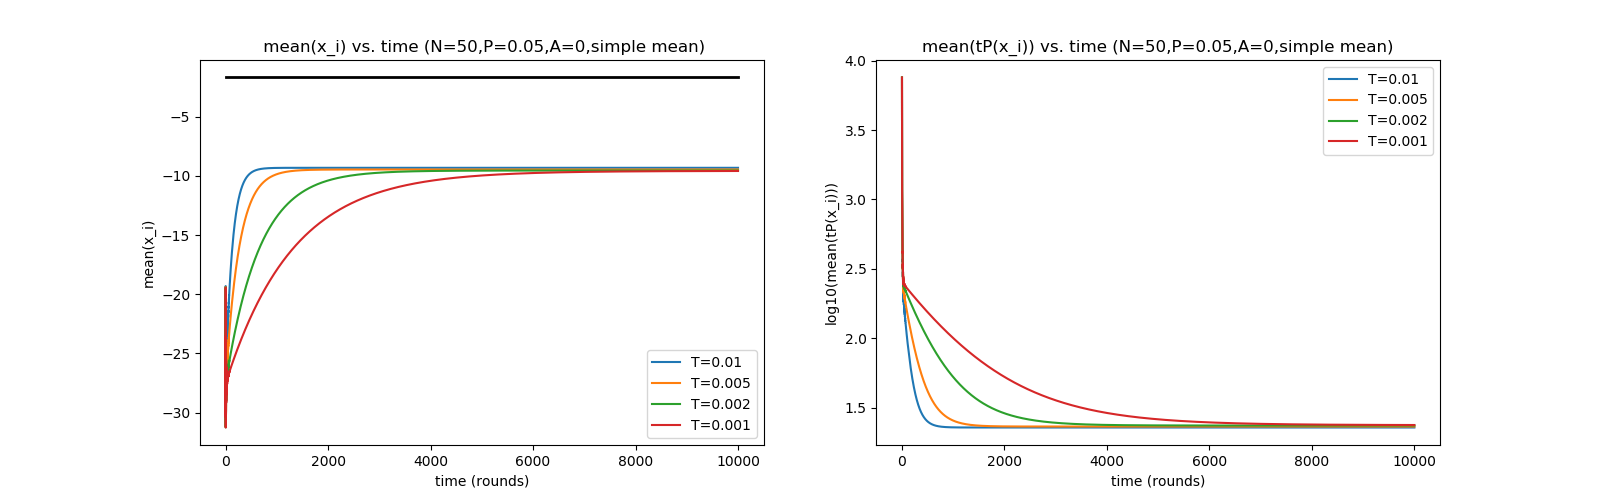

In [9]:
info=open(IOFOLDER+'stats_out.txt','r').read().split('\n')
#print(info)
N,P=list(map(lambda x:float(x),info[0].split('=')[1].split(',')[0:2]))
N=int(N)
A,ITER=list(map(lambda x:int(x),info[2].split('=')[1].split(',')[0:2]))
print('N,P,A,ITER={},{},{},{}'.format(N,P,A,ITER))
TITLE_PARAM='(N={},P={},A={},'+('simple mean' if A==0 else 'trimmed mean[1:-1]')+')'
optloc,optscr=list(map(lambda x:float(x),info[3].split('=')[1].split(',')[0:2]))
print('optloc,optscr={},{}'.format(optloc,optscr))
data={}
T=-1
for i in range(4,len(info)):
    if len(info[i])==0:
        continue
    pcs=info[i].split('=')
    if pcs[0]=='T':
        T=float(pcs[1])
        data[T]={}
    else:
        data[T][pcs[0]]=list(map(lambda x:float(x),pcs[1].split(',')))
fig,(mlocs,mdiffs)=plt.subplots(1,2,figsize=(16,5))
mlocs.set_title(' mean(x_i) vs. time '+TITLE_PARAM.format(N,P,A))
mlocs.set_xlabel('time (rounds)')
mlocs.set_ylabel('mean(x_i)')
mlocs.plot([0,ITER],[optloc,optloc],linewidth=2,c='black')
for T in data:
    mlocs.plot(data[T]['meanloc'],label='T='+str(T))
mlocs.legend()
mdiffs.set_title('mean(tP(x_i)) vs. time '+TITLE_PARAM.format(N,P,A))
mdiffs.set_xlabel('time (rounds)')
mdiffs.set_ylabel('log10(mean(tP(x_i)))')
for T in data:
    mdiffs.plot(list(map(lambda x:np.log10(x),data[T]['meandiff'])),label='T='+str(T))
mdiffs.legend()

In [ ]:
#old Python code for DGD
A=0
F=((lambda x:np.mean(x)) if A==0 else (lambda x:np.mean(x[1:-1])))
ITER=10000
fig,axs=plt.subplots(1,2,figsize=(16,5))
try:
    len(axs)
except TypeError:
    axs=[axs]
TITLE_PARAM='(N={},P={},A={},'+('simple mean' if A==0 else 'trimmed mean[1:-1]')+')'
axs[0].set_title('mean objective diff vs. time '+TITLE_PARAM.format(N,P,A))
axs[0].set_xlabel('time (iterations)')
axs[0].set_ylabel('log10(mean objective diff)')
'''axs[1].set_title('functions')
axs[1].set_xlabel('x')
axs[1].set_ylabel('P_i,tP')
tmp=np.linspace(min(locss[ITER])-200,max(locss[ITER])+200,100)
for P in Ps:
    axs[1].plot(tmp,val(P,tmp),alpha=0.1)
axs[1].plot(tmp,val(tP,tmp),linewidth=3)
axs[1].scatter(x=locss[ITER],y=[val(tP,v) for v in locss[ITER]],s=10,c='black')'''
locsTime=axs[1]
locsTime.set_title(' mean(x_i) vs. time '+TITLE_PARAM.format(N,P,A))
locsTime.set_xlabel('time (rounds)')
locsTime.set_ylabel('mean(x_i)')
locsTime.plot([0,ITER],[optx,optx],linewidth=2,c='black')

for T in [0.01,0.005,0.002,0.001]:
    locs=locs0
    locss=[locs]
    for rep in range(ITER):
        receivedVals=[[] for i in range(N)]
        for i in range(N+A):
            for j in graph[i]:
                if j<N:
                    receivedVals[j].append(locs[i] if i<N else 1000000)
                #                                              ^^^^^^^
                #basic adversary: always send the same big number to all neighbors
                #if "always super high": 1000000
                #if "always super low": -1000000
                #if "half high/half low": (1000000 if j<N/2 else -1000000)
        for i in range(N):
            receivedVals[i].sort()
        nlocs=[F(receivedVals[i])-T*grad(Ps[i],locs[i]) for i in range(N)]
        locs=nlocs
        locss.append(locs)
    meanscr=np.mean([val(tP,locss[ITER][i]) for i in range(N)])
    line='{},{},{},{},{},{}'.format(N,P,A,T,optval,meanscr)
    print(line)
    axs[0].plot([np.log10(np.mean([val(tP,locss[t][i]) for i in range(N)])-optval) for t in range(ITER+1)],label='T='+str(T))
    locsTime.plot([np.mean(locss[t]) for t in range(ITER+1)],linewidth=1,label='T='+str(T))
axs[0].legend()
locsTime.legend()
fig.savefig('tmp',bbox_tight=True)

In [ ]:
#graph network visualization
'''groups=[[] for i in range(N)]
for i in range(N):
    groups[find(info[1],i)].append(i)
seq=[]
for g in groups:
    seq.extend(g)
locs=[[] for i in range(N)]
for i in range(N):
    t=2*math.pi*i/N
    locs[seq[i]]=[math.cos(t),math.sin(t)]
plt.figure()
amt=0
for g in groups:
    if len(g)>0:
        amt+=1
tmp=0
for g in groups:
    if len(g)>0:
        col=(1-tmp/amt,0,tmp/amt)
        for i in g:
            for j in graph[i]:
                plt.plot([locs[i][0],locs[j][0]],[locs[i][1],locs[j][1]],c=col)
        plt.scatter(x=[locs[i][0] for i in g],y=[locs[i][1] for i in g],s=40,c=[col for i in g])
        tmp+=1

for a in range(A):
    graph.append([i for i in range(N)])
    for i in range(N):
        graph[i].append(len(graph)-1)'''